In [1]:
!ls /kaggle/input/american-sign-language-silhouettes/gestures

0  10  12  14  16  18  2   21  23  25  3  5  7	9
1  11  13  15  17  19  20  22  24  26  4  6  8


In [2]:
TRAIN = '/kaggle/input/american-sign-language-silhouettes/gestures'

In [3]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 121MB/s]


In [4]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)

def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'] )
        for index, input_file in enumerate(list(iglob(pathname=arg))) if index < 100]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*') }
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 100 rows of 7  in 0:00:13.059230
encoded 100 rows of 17  in 0:00:13.166810
encoded 100 rows of 19  in 0:00:13.156234
encoded 100 rows of 22  in 0:00:13.053061
encoded 100 rows of 2  in 0:00:13.081999
encoded 100 rows of 23  in 0:00:13.099604
encoded 100 rows of 10  in 0:00:13.184695
encoded 100 rows of 5  in 0:00:13.114404
encoded 100 rows of 20  in 0:00:13.325392
encoded 100 rows of 25  in 0:00:12.845155
encoded 100 rows of 8  in 0:00:13.015428
encoded 100 rows of 12  in 0:00:12.937636
encoded 100 rows of 0  in 0:00:12.704837
encoded 100 rows of 18  in 0:00:13.033057
encoded 100 rows of 16  in 0:00:12.913683
encoded 100 rows of 13  in 0:00:12.713691
encoded 100 rows of 26  in 0:00:12.560867
encoded 100 rows of 15  in 0:00:13.057586
encoded 100 rows of 3  in 0:00:12.979097
encoded 100 rows of 1  in 0:00:12.557298
encoded 100 rows of 14  in 0:00:12.549980
encoded 100 rows of 4  in 0:00:13.153285
encoded 100 rows of 9  in 0:00:12.878134
encoded 100 rows of 21  in 0:00:12.687575
e

In [5]:
from sklearn.manifold import TSNE

train_reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = train_reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 2700 samples in 0.054s...
[t-SNE] Computed neighbors for 2700 samples in 0.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2700
[t-SNE] Computed conditional probabilities for sample 2000 / 2700
[t-SNE] Computed conditional probabilities for sample 2700 / 2700
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.181396
[t-SNE] KL divergence after 1000 iterations: 0.664744


In [6]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: ASL silhouettes', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=9, color=mapper)
show(plot_figure)

Loading BokehJS ...

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.25, random_state=2025, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=5000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 781 iterations
accuracy: 0.9867
f1: 0.9866
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.96      1.00      0.98        25
          10       1.00      1.00      1.00        25
          11       1.00      1.00      1.00        25
          12       0.93      1.00      0.96        25
          13       1.00      0.96      0.98        25
          14       1.00      1.00      1.00        25
          15       1.00      1.00      1.00        25
          16       1.00      1.00      1.00        25
          17       1.00      1.00      1.00        25
          18       1.00      1.00      1.00        25
          19       1.00      0.96      0.98        25
           2       1.00      1.00      1.00        25
          20       1.00      1.00      1.00        25
          21       1.00      0.96      0.98        25
          22       1.00      1.00      1.00        25
          23       1.00  

<Axes: xlabel='probability', ylabel='Count'>

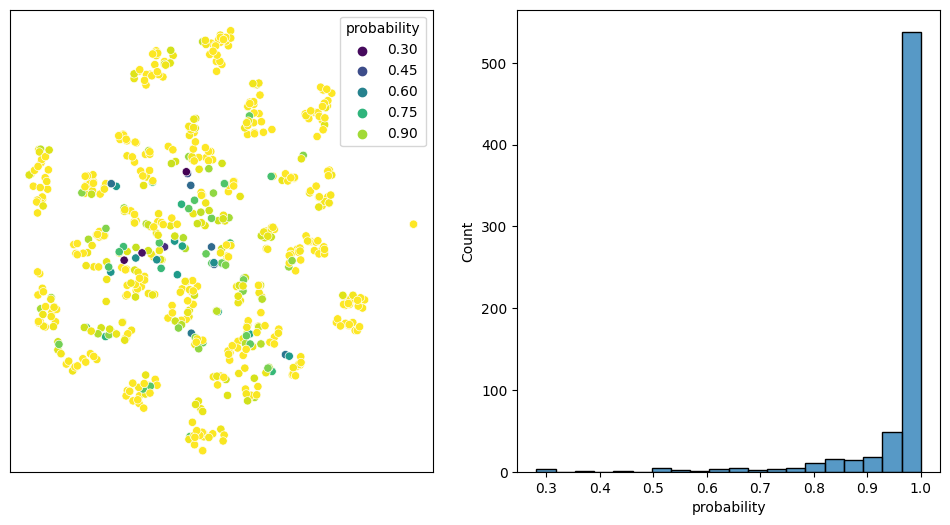

In [8]:
import matplotlib.pyplot as plt
import warnings
from seaborn import histplot
from seaborn import scatterplot

warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')

plot_df = train_df.iloc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)

plt, ax = plt.subplots(ncols=2, figsize=(12, 6))
scatterplot(ax=ax[0], data=plot_df, x='x', y='y', hue='probability', palette='viridis')
ax[0].set(xlabel=None) 
ax[0].set(ylabel=None)
ax[0].set(xticklabels=[])
ax[0].set(yticklabels=[])
ax[0].tick_params(axis='both', which='both', length=0)
histplot(ax=ax[1], data=plot_df, x='probability', bins=20)